In [1]:
import csv
import cv2
import numpy as np
import time


In [22]:
file_contains_header = False
dev_mode = False
no_of_images_to_read_in_dev_mode = 4


In [23]:
# Read the data collected in csv file

samples = []

def read_samples(filename):
    with open(filename) as csvFile:
        reader = csv.reader(csvFile)
        first_line = True
        for sample in reader:
            if(first_line and file_contains_header):
                first_line = False
                continue
            samples.append(sample)
            if(dev_mode and len(samples) >= no_of_images_to_read_in_dev_mode):
                break


read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_forward_2_laps/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_reverse_2_laps/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track1_shoulder_to_road_1_lap/driving_log.csv')
read_samples('../CarND-Behavioral-Cloning-P3-My-Data/track2_forward_2_laps/driving_log.csv')


sample count is  17355
sample count is  17355
steering_angles  17355
hist  [  407   144   129   247   249   363   446   567   582   437 11030   541
   471   400   260   267   267   127   152   269]
bins  [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


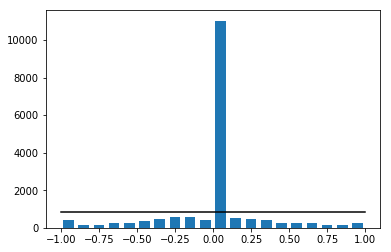

In [73]:
# Print the histogram of the data points
print('sample count is ', len(samples))

from sklearn.utils import shuffle
samples = shuffle(samples)
print('sample count is ', len(samples))

def visualize_steering_angles_histogram(samples):
    steering_angles = []

    for sample in samples:
        steering_angles.append(sample[3])
    steering_angles = np.array(steering_angles).astype(np.float)
    #print(samples[:][3])
    print('steering_angles ', len(steering_angles))
    #steering_angles = steering_angles[0:5000]
    #print('steering_angles ', len(steering_angles))


    import matplotlib.pyplot as plt

    num_bins = 20
    avg_samples_per_bin = len(steering_angles)/num_bins
    hist, bins = np.histogram(steering_angles, num_bins)

    print('hist ', hist)
    print('bins ', bins)

    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.plot((np.min(steering_angles), np.max(steering_angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
    #plt.show()
    
visualize_steering_angles_histogram(samples)

steering_angles  7655
hist  [ 407  144  129  247  249  363  446  567  582  437 1330  541  471  400
  260  267  267  127  152  269]
bins  [-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


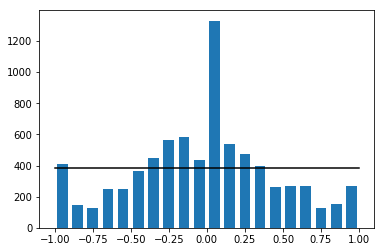

In [83]:
# Flatten the data points
flattened_samples = []

steering_angle_to_flatten = 0

count = 0
for sample in samples:
    if(float(sample[3]) == steering_angle_to_flatten):
        if(count <= avg_samples_per_bin):
            flattened_samples.append(sample)
        count = count+1
    else:
        flattened_samples.append(sample)
 
#avg_samples_per_bin = len(steering_angles)/num_bins
#hist, bins = np.histogram(steering_angles, num_bins)
#plt.bar(center, hist, align='center', width=width)
#plt.plot((np.min(flattened_samples), np.max(flattened_samples)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')


visualize_steering_angles_histogram(flattened_samples)

samples = flattened_samples

In [14]:
start_time = time.time()



# Split the data between training and validation set
from sklearn.model_selection import train_test_split
from random import shuffle
train_samples, validation_samples = train_test_split(samples, test_size=0.2)



In [15]:
image_shape = (160,320,3)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    #relative_path = '../CarND-Behavioral-Cloning-P3-data/data/IMG'
    relative_path = '../CarND-Behavioral-Cloning-P3-My-Data'
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset: offset+batch_size]
            images = []
            measurements = []
            
            for batch_sample in batch_samples:
                for i in range(3):
                    image_file_name = batch_sample[i].split(':')[-1]

                    relative_file_name = relative_path + image_file_name
                    relative_file_name = relative_file_name.replace('\\','//')
                    input_image = cv2.imread(relative_file_name)

                    #print(batch_sample[i].split(':'))
                    #print('image_file_name ', image_file_name)
                    #print('relative_file_name ', relative_file_name)
                    #print('input_image file name ', relative_file_name)
                    #print('input_image ', input_image)
                    #print('input_image.shape ', input_image.shape)

                    images.append(input_image)

                    measurement = float(batch_sample[3])
                    correction_factor = 0.2
                    if(i == 1):
                        measurement = measurement + correction_factor
                    elif(i == 2):
                        measurement = measurement - correction_factor
                    measurements.append(measurement)

                    # Augment data by flipping the image and negating the measurement
                    images.append(cv2.flip(input_image,1))
                    measurements.append(-1.0 * measurement)

            X_train = np.array(images)
            y_train = np.array(measurements)
            #import sklearn.utils.shuffle
            yield (X_train, y_train)

print('no. of training samples is  ', len(train_samples))
print('no. of validation samples is  ', len(validation_samples))

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

print("calling the train generator")
#print((next(train_generator)))

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, MaxPooling2D, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(image_shape)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

# Lenet Architecture
#model.add(Convolution2D(6,5,5, activation = "relu"))
#model.add(MaxPooling2D())
#model.add(Convolution2D(6,5,5, activation = "relu"))
#model.add(MaxPooling2D())
#model.add(Flatten())
#model.add(Dense(120))
#model.add(Dense(84))
#model.add(Dense(1))

# NVIDIA Architecture
model.add(Convolution2D(24,5,5, subsample=(2,2), activation = "relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation = "relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation = "relu"))
model.add(Convolution2D(64,3,3, activation = "relu"))
model.add(Convolution2D(64,3,3, activation = "relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam')

#model.fit(X_train, y_train, shuffle=True, validation_split=0.2, nb_epoch=5)
model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=3)


model.save('model.h5')

print('Time Taken to load the images and train the model : ', time.time() - start_time)



no. of training samples is   5
no. of validation samples is   2
calling the train generator
Epoch 1/3
30/5 [====================================================================================================================================================================================] - 0s - loss: 0.0253 - val_loss: 0.0184

/Users/tavant/miniconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/3
30/5 [====================================================================================================================================================================================] - 0s - loss: 0.0136 - val_loss: 0.0369
Epoch 3/3
30/5 [====================================================================================================================================================================================] - 0s - loss: 0.0655 - val_loss: 0.0156
Time Taken to load the images and train the model :  4.412271022796631
